In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
import tensorflow as tf

#sys.path.append('..')
from worldmodels.memory.memory import GaussianMixture, MLP

In [3]:
NSAMPLE = 5000

y_data = np.random.uniform(-10.5, 10.5, (1, NSAMPLE)).T
r_data = np.random.normal(size=(NSAMPLE,1))
x_data = np.sin(0.75*y_data)*7.0+y_data*0.5+r_data*1.0

num_timesteps = 1
num_features = 1
num_mix = 24
batch_size = NSAMPLE

y_data = y_data.reshape(NSAMPLE, num_timesteps, num_features).astype(np.float32)
x_data = x_data.reshape(NSAMPLE, num_timesteps, num_features).astype(np.float32)

#  this will be the shape of the output of the lstm
#  (batch_size, num_timesteps, output_dim * num_mix * 3)
#  three for one pi, mu, sigma for each mixture
mixture_dim = num_features * num_mix * 3
print(mixture_dim)

72


In [4]:
memory = MLP(num_mix, hidden_nodes=24)

In [5]:
mixture = GaussianMixture(num_features, num_mix, num_timesteps=1, batch_size=batch_size)

In [6]:
x_sample = x_data[0:2]
x_sample.shape

(2, 1, 1)

In [7]:
pi, mu, sigma = mixture(memory(x_data))

In [8]:
x_data[0:2]

array([[[ 7.5821185]],

       [[-2.7585025]]], dtype=float32)

In [9]:
y_data[0:2]

array([[[ 1.5589547 ]],

       [[-0.57944673]]], dtype=float32)

In [10]:
optimizer = tf.keras.optimizers.Adam()

def train_op(memory, mixture, x, y):
    with tf.GradientTape() as tape:
        loss = mixture.get_loss(memory(x), y)
        gradients = tape.gradient(loss, memory.trainable_variables)

    optimizer.apply_gradients(zip(gradients, memory.trainable_variables))
    
    return loss

dataset = tf.data.Dataset.from_tensor_slices((x_data, y_data)).shuffle(NSAMPLE).batch(batch_size)
epochs = 5000
loss = np.zeros(epochs)

for epoch in range(epochs):
    for batch in dataset:
        loss[epoch] = train_op(memory, mixture, *batch)
    if epoch % 500 == 1:
        print(epoch, loss[epoch])

1 6.649377346038818
501 2.0860071182250977
1001 1.6808706521987915
1501 1.5410535335540771
2001 1.4718093872070312
2501 1.4358093738555908
3001 1.4188294410705566
3501 1.4054757356643677
4001 1.3943802118301392
4501 1.346665382385254


In [11]:
import matplotlib.pyplot as plt
plt.figure(figsize=(8, 8))
plt.plot(np.arange(epochs), loss[:epochs], 'r-')
plt.show()

<Figure size 800x800 with 1 Axes>

In [12]:
x_test = np.float32(np.arange(-15,15,0.1))
n_test = x_test.shape[0]
x_test = x_test.reshape(n_test, 1, 1)

In [19]:
def get_pi_idx(pis):
    x = np.random.rand(1)
    pdf = 0
    
    for idx, prob in enumerate(pis[0, 0, :]):
        pdf += prob.numpy()
        if pdf >= x:
            return idx
        
    raise ValueError()
    
from worldmodels.memory.memory import get_pi_idx

In [20]:
pi.shape

TensorShape([1, 1, 1, 24])

In [23]:
mus, sigmas, idxs = np.zeros(n_test), np.zeros(n_test), np.zeros(n_test)

samples = np.zeros(n_test)

for num, sample in enumerate(x_test):

    pi, mu, sigma = mixture(memory(sample.reshape(1, 1, 1)))
    
    idx = get_pi_idx(pi, None)
    
    idxs[num] = idx
    mus[num] = mu[:, :, :, idx]
    sigmas[num] = sigma[:, :, :, idx]
    
    samples[num] = mus[num] + np.random.randn() * sigmas[num]


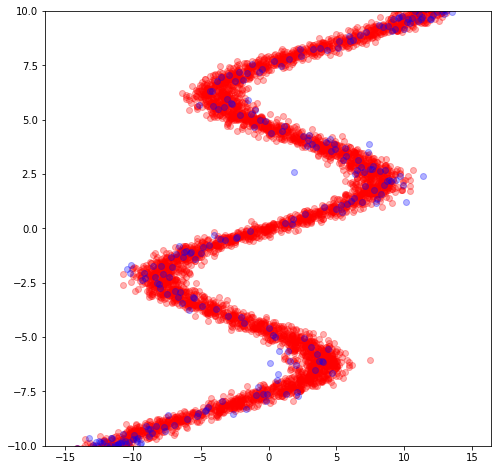

In [24]:
plt.figure(figsize=(8, 8))
plt.plot(np.squeeze(x_data),np.squeeze(y_data), 'ro', np.squeeze(x_test), np.squeeze(samples), 'bo', alpha=0.3)

plt.ylim(-10, 10)
plt.show()

## LSTM head

In [25]:
from worldmodels.memory.memory import Memory
from worldmodels.memory.train_memory import train
worldmodels = Memory(input_dim=1, output_dim=num_features, num_timesteps=num_timesteps, batch_size=batch_size, lstm_nodes=24, num_mix=24,
                    decay_steps=NSAMPLE*epochs)

In [ ]:
x = x_data
y = y_data

dataset = tf.data.Dataset.from_tensor_slices((x, y)).shuffle(x.shape[0]).batch(batch_size)
epochs = 5000
for epoch in range(epochs):
    for batch in dataset:
        state = worldmodels.lstm.get_zero_hidden_state(x)
        loss[epoch] = worldmodels.train_op(*batch, state)
    if epoch % 500 == 1:
        print(epoch, loss[epoch])

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize=(8, 8))
plt.plot(np.arange(epochs), loss[:epochs], 'r-')
plt.show()

In [ ]:
sample.reshape(1, 1, 1)

In [ ]:
mus, sigmas, idxs = np.zeros(n_test), np.zeros(n_test), np.zeros(n_test)

samples = np.zeros(n_test)

for num, sample in enumerate(x_test):

    latent, _, _ = world_models.lstm.net(sample.reshape(1, 1, 1))
    
    pi, mu, sigma = world_models.mixture(latent)
    
    idx = get_pi_idx(pi)
    
    idxs[num] = idx
    mus[num] = mu[:, :, idx]
    sigmas[num] = sigma[:, :, idx]
    
    samples[num] = mus[num] + np.random.randn() * sigmas[num]

In [ ]:
plt.figure(figsize=(8, 8))
plt.plot(np.squeeze(x_data),np.squeeze(y_data), 'ro', np.squeeze(x_test), np.squeeze(samples), 'bo', alpha=0.3)

plt.ylim(-10, 10)
plt.show()

In [ ]:
dir(world_models)